In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from keras import models, layers
from datetime import date
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score


def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) 

## Resampling the data on a daily basis

In [2]:
df = pd.read_csv("bitcoin_price.csv")
df.drop(['Open','Close','Volume_(BTC)','Volume_(Currency)','High','Low'],axis=1, inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('Timestamp') #set the index to Timestamp
df_day = df.resample('D').mean() #Downsample into daily samples

## Finding the NaNs in the dataset

In [2]:
# Find missing values
for i, r in df_day.iterrows():
    if r.isnull().sum() > 0:
        print(i)
        print(r)
        print()

# Print the records of the date between the missing records
print()
print('Data at 2015-01-05')
print(df_day.loc['2015-01-05'])

print()
print('Data at 2015-01-09')
print(df_day.loc['2015-01-09'])

df_day.head(5)

2015-01-06 00:00:00
Weighted_Price   NaN
Name: 2015-01-06 00:00:00, dtype: float64

2015-01-07 00:00:00
Weighted_Price   NaN
Name: 2015-01-07 00:00:00, dtype: float64

2015-01-08 00:00:00
Weighted_Price   NaN
Name: 2015-01-08 00:00:00, dtype: float64


Data at 2015-01-05
Weighted_Price    272.13919
Name: 2015-01-05 00:00:00, dtype: float64

Data at 2015-01-09
Weighted_Price    291.885251
Name: 2015-01-09 00:00:00, dtype: float64


,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


## Replace the NaNs with the mean value of the day before and after

In [3]:
missing_replacement = df['2015-01-05': '2015-01-09'].mean(numeric_only=True)
df_day.loc['2015-01-06'] = missing_replacement
df_day.loc['2015-01-07'] = missing_replacement
df_day.loc['2015-01-08'] = missing_replacement

# Any missing value?
df_day.isnull().sum(),df_day.head()

(Weighted_Price    0
 dtype: int64,
             Weighted_Price
 Timestamp                 
 2011-12-31        4.471603
 2012-01-01        4.806667
 2012-01-02        5.000000
 2012-01-03        5.252500
 2012-01-04        5.208159)

## Scale the dataset from 0 to 1

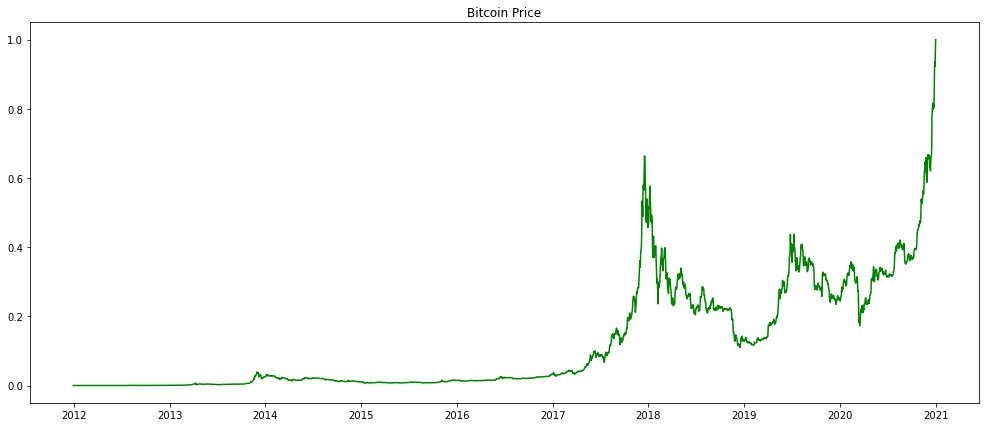

(3289, 1)

In [4]:
scaler = MinMaxScaler()
price = scaler.fit_transform(np.array(df_day['Weighted_Price']).reshape(-1,1))
df_day['Weighted_Price'] = price
plt.figure(figsize=(17,7))
plt.plot(df_day, 'green' )
plt.title('Bitcoin Price')

plt.show()
df_day.shape

## Define the window size and split the training test data

In [5]:
window_size = (date(2020, 8, 18) - date(2020, 5, 10)).days
df_train = df_day.loc['2011-12-31':'2019-12-31']# training the model with data set before 2019-12-31
df_test = df_day.loc['2020-01-01':]
X_l = []
y_l = []
N = len(df_train)
D = window_size
for i in range(N-D-1):
    X_l.append(df_train.iloc[i:i+D])
    y_l.append(df_train.iloc[i+D])
    
X = np.array(X_l)
y = np.array(y_l)

print(X.shape, y.shape)
df_day.shape

(2822, 100, 1) (2822, 1)


(3289, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 100)


## Define the MLP model

In [9]:

mlp = Sequential()
mlp.add(Dense(16, input_shape=X_train.shape[1:], activation='relu'))
mlp.add(Dense(8, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.compile('adam','mse')
mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100, 16)           32        
_________________________________________________________________
dense_4 (Dense)              (None, 100, 8)            136       
_________________________________________________________________
dense_5 (Dense)              (None, 100, 1)            9         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


## Training period (500 epochs)

In [10]:
history = mlp.fit(np.array(X_train), np.array(y_train), epochs=500, validation_data=(np.array(X_test),np.array(y_test)),verbose=1)

Epoch 1/500
71/71 [==============================] - 1s 9ms/step - loss: 0.1538 - val_loss: 0.1254
Epoch 2/500
71/71 [==============================] - 0s 3ms/step - loss: 0.0878 - val_loss: 0.0581
Epoch 3/500
71/71 [==============================] - 0s 3ms/step - loss: 0.0396 - val_loss: 0.0275
Epoch 4/500
71/71 [==============================] - 0s 3ms/step - loss: 0.0229 - val_loss: 0.0184
Epoch 5/500
71/71 [==============================] - 0s 3ms/step - loss: 0.0168 - val_loss: 0.0136
Epoch 6/500
71/71 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.0084
Epoch 7/500
71/71 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 8/500
71/71 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 9/500
71/71 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 10/500
71/71 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 11/

In [11]:
mlp.save('my_MLPmodel.h5')

## Plot the loss evaluation during training

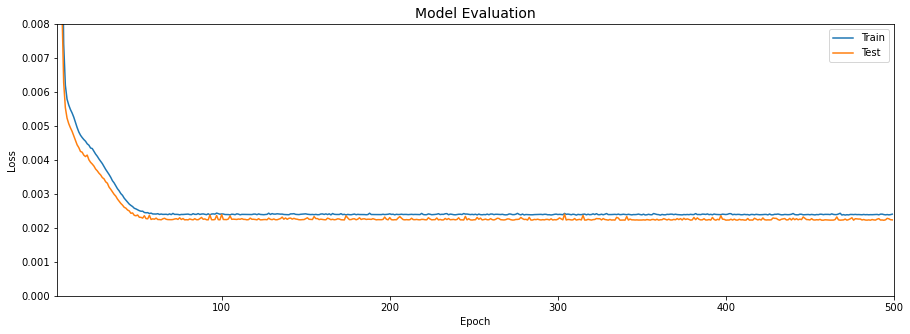

In [12]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','Test'])
plt.title("Model Evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.xlim(2,500)
plt.ylim(0, 0.008)
plt.ylabel('Loss')
plt.savefig('MLP model evaluation.png')
plt.show()

## Predict the Bitcoin price 

In [17]:
mlp=models.load_model('my_MLPmodel.h5')
pred_mlp = []
np.array(df_day[2822+i:2922]).shape
pr_mlp = mlp.predict(df_day[2822:2922]) # use the 100 data before 2019-12-31 to predict the next (future) 100 prices.
pred_mlp.append(pr_mlp[0])
for i in range(1,100):
    pr_mlp = mlp.predict(np.append(np.array(df_day[2822+i:2922]),pred_mlp[:]))  # one-step ahead prediction
    print(pr_mlp[0])
    pred_mlp.append(pr_mlp[0])



[[0.30370626]]
[[0.29749483]]
[[0.28442392]]
[[0.28181803]]
[[0.27903187]]
[[0.2805989]]
[[0.27948648]]
[[0.27946895]]
[[0.283279]]
[[0.28189713]]
[[0.2817316]]
[[0.28044057]]
[[0.27993274]]
[[0.27826104]]
[[0.27905214]]
[[0.28126603]]
[[0.28296787]]
[[0.2859068]]
[[0.2837621]]
[[0.28290525]]
[[0.28322896]]
[[0.28256613]]
[[0.28198478]]
[[0.27936298]]
[[0.2789483]]
[[0.27803358]]
[[0.27799124]]
[[0.27878428]]
[[0.28143543]]
[[0.28113478]]
[[0.27508968]]
[[0.27138942]]
[[0.27696094]]
[[0.2960769]]
[[0.29735965]]
[[0.2982214]]
[[0.2969548]]
[[0.29437733]]
[[0.29410064]]
[[0.29386204]]
[[0.29556552]]
[[0.29470763]]
[[0.2952435]]
[[0.29641873]]
[[0.29630786]]
[[0.29497674]]
[[0.29148757]]
[[0.28923732]]
[[0.2903866]]
[[0.2889991]]
[[0.28821617]]
[[0.28839839]]
[[0.2871682]]
[[0.2856261]]
[[0.28470308]]
[[0.2852863]]
[[0.28349745]]
[[0.28003103]]
[[0.27980718]]
[[0.2765292]]
[[0.26999897]]
[[0.26872796]]
[[0.26749647]]
[[0.26515692]]
[[0.26743105]]
[[0.26885122]]
[[0.27231735]]
[[0.27347744

## Plot the prediction results

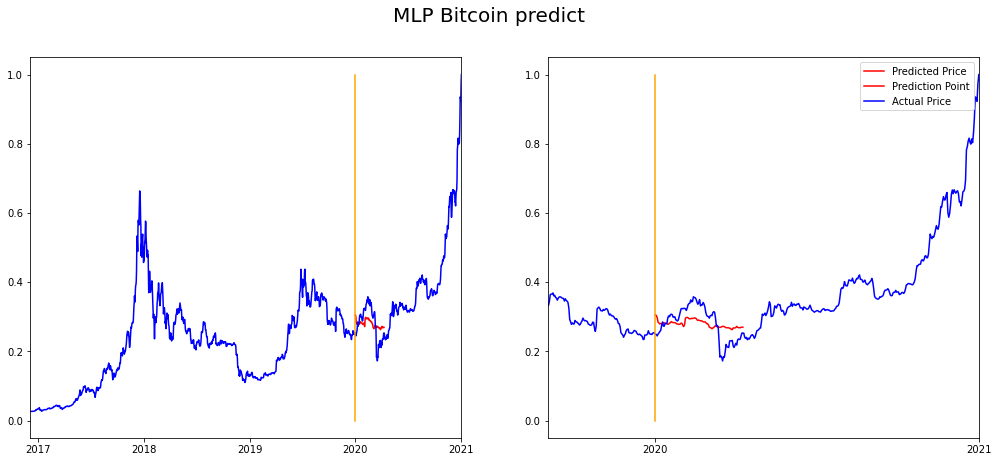

       price
0   0.305102
1   0.303706
2   0.297495
3   0.284424
4   0.281818
..       ...
95  0.268455
96  0.268081
97  0.269447
98  0.270048
99  0.269437

[100 rows x 1 columns]


((3289, 1), (100, 2))

In [18]:
pred_mlp = pd.DataFrame(np.reshape(pred_mlp,(100,1)))

pred_mlp = pred_mlp.reset_index()

pred_mlp.columns = ['z','price']

pred_mlp.drop(['z'],axis=1,inplace=True)


plot_data= df_day.reset_index().drop('Timestamp',axis=1)
plot_data1=plot_data[:2922]
data = pd.concat([plot_data1,pred_mlp],ignore_index=True) # concat the data before prediction time point with prediction result

plt.figure(figsize=(17,7))

plt.subplot(1, 2, 1)

plt.plot(data[-100:],'red')
plt.plot(plot_data,'blue')
plt.plot([2922, 2922], [0, 1], 'orange')
plt.xticks([0, 366, 731,1096,1461,1827,2192,2557,2922,3288], ['2012', '2013', '2014','2015','2016','2017','2018','2019','2020','2021'])  # Set text labels and properties.
plt.xlim(1800,3288)


plt.subplot(1, 2, 2)

plt.plot(data[-100:],'red')
plt.plot(plot_data,'blue')
plt.plot([2922, 2922], [0, 1], 'orange')
plt.xticks([0, 366, 731,1096,1461,1827,2192,2557,2922,3288], ['2012', '2013', '2014','2015','2016','2017','2018','2019','2020','2021'])  # Set text labels and properties.
plt.legend(['Predicted Price','Prediction Point','Actual Price'])
plt.xlim(2800,3288)

plt.suptitle("MLP Bitcoin predict",fontsize=20)

plt.savefig('MLPpred')
plt.show()

print(pred_mlp)
plot_data.shape,data[-100:].shape

## Performance Evaluation

In [19]:
y_test = df_test.Weighted_Price.values[0:window_size]
mean_squared_error(y_test, pred_mlp, squared=False) #Root mean squared error

0.04294842519679459

In [20]:
mean_absolute_percentage_error(y_test, pred_mlp)  # mean absolute percentage error

0.14266454842609907

In [22]:
r2_score(y_test, pred_mlp), mean_absolute_error(y_test, pred_mlp)

(0.22542188622237969, 0.03711467221696619)